# import and visualize oil data

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [22]:
oildata = pd.read_csv('oil.csv',sep=',',header=0,index_col=0)
oildata.head()

,OilProduction
1965,111.009135
1966,130.828434
1967,141.287088
1968,154.227775
1969,162.740865


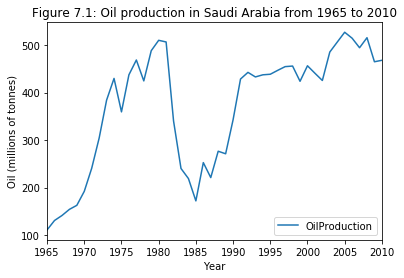

In [23]:
plt.figure();
axes = oildata.plot();
axes.set_xlabel('Year')
axes.set_ylabel('Oil (millions of tonnes)')
axes.set_title('Figure 7.1: Oil production in Saudi Arabia from 1965 to 2010');

# Reproduce plot in Figure 7.2

adjust=False specification in the ewm method ensures that weighted averages are calculated recursively as:

weighted_average[0] = data[0]; weighted_average[i] = (1-alpha) X weighted_average[i-1] + alpha X data[i].

In [24]:
# extract data from 1996 to 2007 and perform SES
trainOilData =  oildata.loc[1996:2007].rename(index=str, columns={"OilProduction": "Observed values"})
fit1 = trainOilData.ewm(alpha=0.2,adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=0.2"})
fit2 = trainOilData.ewm(alpha=0.6,adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=0.6"})
combined = pd.concat([trainOilData,fit1,fit2],axis=1)
combined


,Observed values,alpha=0.2,alpha=0.6
1996,446.656523,446.656523,446.656523
1997,454.473307,448.219880,451.346593
1998,455.662974,449.708498,453.936422
1999,423.632239,444.493247,435.753912
2000,456.271328,446.848863,448.064362
2001,440.588050,445.596700,443.578575
2002,425.332520,441.543864,432.630942
2003,485.149448,450.264981,464.142046
2004,506.048162,461.421617,489.285715
2005,526.791983,474.495690,511.789476


In [25]:
# optimal parameter estimation in scipy
def func(x,y):
    fit = np.zeros((y.size))
    fit[0] = x[0]
    obj = (fit[0]-y[0])*(fit[0]-y[0])
    for i in range(1,y.size):
        fit[i] = x[1]*y[i-1]+(1-x[1])*fit[i-1]
        obj = obj + (fit[i]-y[i])*(fit[i]-y[i])
    return obj

bnds = ((0, 1000), (0, 1))
res = minimize(func, [trainOilData.iloc[0,0],0.5],args=trainOilData.iloc[:,0].values,bounds=bnds, method='SLSQP', options={'disp': False})
print(res.x)

[ 447.47832041    0.8920028 ]


In [26]:
# fit using optimal alpha
fit_opt = trainOilData.ewm(alpha=res.x[1],adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=opt"})
combined = pd.concat([trainOilData,fit1,fit2,fit_opt],axis=1)
combined

,Observed values,alpha=0.2,alpha=0.6,alpha=opt
1996,446.656523,446.656523,446.656523,446.656523
1997,454.473307,448.219880,451.346593,453.629116
1998,455.662974,449.708498,453.936422,455.443323
1999,423.632239,444.493247,435.753912,427.067747
2000,456.271328,446.848863,448.064362,453.117423
2001,440.588050,445.596700,443.578575,441.941187
2002,425.332520,441.543864,432.630942,427.126210
2003,485.149448,450.264981,464.142046,478.883100
2004,506.048162,461.421617,489.285715,503.114411
2005,526.791983,474.495690,511.789476,524.234872


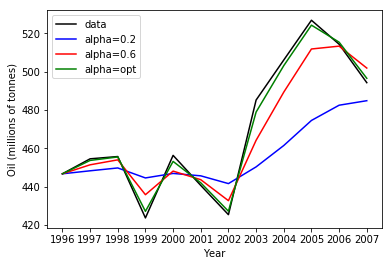

In [27]:
# plot graphs
fig, axes = plt.subplots()
axes.plot(trainOilData.index,trainOilData,color='black',label='data')
axes.plot(fit1.index,fit1,color='blue',label='alpha=0.2')
axes.plot(fit2.index,fit2,color='red',label='alpha=0.6')
axes.plot(fit_opt.index,fit_opt,color='green',label='alpha=opt')
axes.set_xlabel('Year')
axes.set_ylabel('Oil (millions of tonnes)')
axes.legend();

Note that the plot for alpha = 0.89 is not correct in the book.
For instance, for the year 2004, the smoothed level in the graph is around 480 while the correct value in the table is 503.1.

# Reproduce Holt's linear trend method data in Table 7.3

In [41]:
alpha = 0.8
beta_star = 0.2
airdata = pd.read_csv('ausair.csv',sep=',',header=0,index_col=0).loc[1990:2004]
air = airdata.iloc[:,0].values
years = airdata.index.values

# fit SES
fitSES = np.zeros((air.size))
fitSES[0] = air[0]
for i in range(1,air.size):
    fitSES[i] = alpha*air[i]+(1-alpha)*fitSES[i-1]
    
## fit Holt's linear trend method
# initialize arrays
fitHolt = np.zeros((air.size))
bt = np.zeros((air.size))
yt = np.zeros((air.size))

# compute initial value estimates
fitHolt_o = air[0] # note that level is plotted
b_o = air[1]-air[0]
yt[0] = fitHolt_o+b_o
fitHolt[0] = alpha*air[0]+(1-alpha)*yt[0]
bt[0] = beta_star*(fitHolt[0]-fitHolt_o)+(1-beta_star)*b_o

# compute levels for the time-series
for i in range(1,air.size):
    yt[i] = fitHolt[i-1]+bt[i-1]
    fitHolt[i] = alpha*air[i]+(1-alpha)*yt[i]
    bt[i] = beta_star*(fitHolt[i]-fitHolt[i-1])+(1-beta_star)*bt[i-1]

# tabulate
combined_SES_Holt = np.column_stack((air,fitHolt,fitSES))
table = pd.DataFrame(data=combined_SES_Holt,index=years,columns=['air','Holt','SES'])
table

,air,Holt,SES
1990,17.553400,18.414740,17.553400
1991,21.860100,21.894554,20.998760
1992,23.886600,24.206204,23.309032
1993,26.929300,27.051557,26.205246
1994,26.888500,27.568427,26.751849
1995,28.831400,29.117332,28.415490
1996,30.075100,30.376324,29.743178
1997,30.953500,31.282647,30.711436
1998,30.185700,30.797008,30.290847
1999,31.579700,31.717271,31.321929


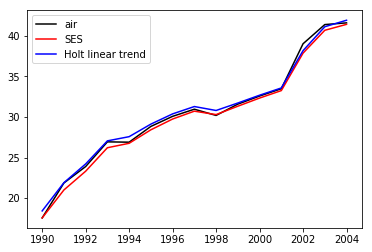

In [37]:
# visualize
plt.plot(years,air,color='black',label='air')
plt.plot(years,fitSES,color='red',label='SES')
plt.plot(years,fitHolt,color='blue',label='Holt linear trend')
plt.legend(loc='best')

# Reproduce results for Holt-Winters Additive method

In [46]:
# read data
aust = pd.read_csv('austourists.csv',sep=',',header=0,index_col=0)
austdata = aust.iloc[20:,0].values

# initialize arrays
yhat = np.zeros((len(austdata)))
l = np.zeros((len(austdata)))
b = np.zeros((len(austdata)))
s = np.zeros((len(austdata)))

# put initial estimates as given in the book
l[3] = 33.8
b[3] = 0.65
s[0], s[1], s[2], s[3] = 10.7, -9.5, -2.6, 1.4

# put estimated parameters
alpha = 0.025
beta = 0.023
gamma = 0
m = 4

# One-step forecasts
for i in range(4,len(austdata)):
    yhat[i] = l[i-1]+b[i-1]+s[i-1-m+1] # hm is 1
    l[i] = alpha*(austdata[i]-s[i-m])+(1-alpha)*(l[i-1]+b[i-1])
    b[i] = beta*(l[i]-l[i-1])+(1-beta)*b[i-1]
    s[i] = gamma*(austdata[i]-l[i-1]-b[i-1])+(1-gamma)*s[i-m]

combined_data = np.column_stack((austdata,l,b,s,yhat)) 
HW_additive = combined_data[4:,:] 

# create dataframe object
table = pd.DataFrame(data=HW_additive,index=range(1,25),columns=['yt','lt','bt','st','yt_hat'])
display(table)

,yt,lt,bt,st,yt_hat
1,41.727458,34.364436,0.648032,10.7,45.150000
2,24.041850,34.975703,0.647186,-9.5,25.512468
3,32.328103,35.605520,0.646787,-2.6,33.022889
4,37.328708,36.244217,0.646601,1.4,37.652307
5,46.213153,36.856376,0.645809,10.7,47.590818
6,29.346326,37.535788,0.646582,-9.5,28.002185
7,36.482910,38.204883,0.647099,-2.6,35.582370
8,42.977719,38.920126,0.648667,1.4,40.251983
9,48.901525,39.534611,0.647881,10.7,50.268793
10,31.180221,40.194935,0.648167,-9.5,30.682492


Note that the values of bt in Table 7.5 does not seem right.
For example, for the given estimated value of β*=0.023, the value of bt for 2005 Q1 should be 0.648 as per the level component formula but it is 0.57 in the book.

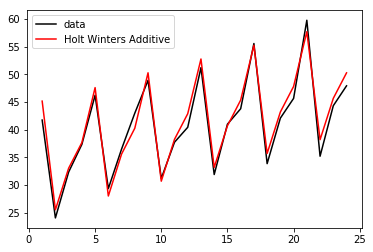

In [45]:
# visualize 
plt.plot(range(1,25),austdata[4:],color='black',label='data')
plt.plot(range(1,25),yhat[4:],color='red',label='Holt Winter''s Additive')
plt.legend(loc='best')